In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import newton

from utils import *

from ipywidgets import interact

import torch
from torch import nn
import torch.nn.functional as F

from pytorch_sparse_utils import *

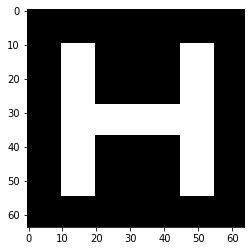

In [2]:
spread = [10,10]
size = 64
shape = (size, size)
pixels = shape[0] * shape[1]

x_true = build_x_true().reshape(-1,1)

plt.imshow(im(x_true, shape), cmap='Greys_r')

In [3]:
Q,H = arnoldi(x_true.reshape(shape)+1, n=5, q_0 = x_true.reshape(shape)[:,0].reshape(-1,1)+1)

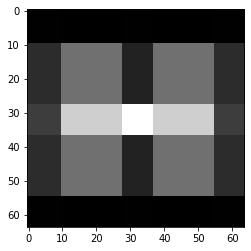

In [4]:
plt.imshow( (Q @ H @ Q[:,:-1].T) , cmap='Greys_r')

In [5]:
(H @ Q[:,:-1].T).shape

(6, 64)

In [6]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, rows, cols, n_factors=10):
        super().__init__()
        self.rows = rows
        self.cols = cols
        self.row_embedding = torch.nn.parameter.Parameter(torch.ones(rows, n_factors)*(1/n_factors**2), requires_grad=True)
        self.col_embedding = torch.nn.parameter.Parameter(torch.ones(n_factors, cols)*(1/n_factors**2), requires_grad=True)

    def forward(self, row_indices, col_indices):
        return torch.matmul( self.row_embedding[row_indices, :], self.col_embedding[:, col_indices] )

In [7]:
device = torch.device('cuda:0')

In [8]:
mf = MatrixFactorization(64, 64, 10).to(device=device)

In [9]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(mf.parameters(), lr=0.001)

In [10]:
im_true = torch.Tensor(x_true.reshape(shape)).to(device=device)

In [11]:
for epoch in range(1000):
    
    optimizer.zero_grad()

    output = mf.forward(list(range(0, 64)), list(range(0, 64)) )
    loss = criterion(output,im_true)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(loss)

tensor(0.2741, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1867, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0648, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0430, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0417, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)


In [12]:
torch.linalg.norm((mf.row_embedding @ mf.col_embedding) - im_true)

tensor(13.0213, device='cuda:0', grad_fn=<CopyBackwards>)

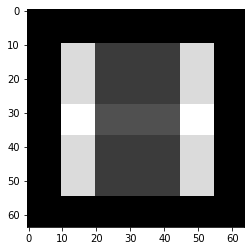

In [13]:
plt.imshow( (mf.row_embedding @ mf.col_embedding).cpu().detach().numpy() , cmap='Greys_r')

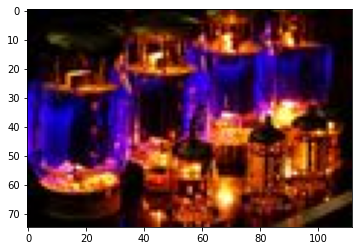

In [14]:
from matplotlib.image import imread

data = imread('../data/vacuum_tubes.jpg')
im_true = torch.Tensor(data/data.max())

plt.imshow(im_true.detach().numpy())

In [15]:
rows = np.arange(75)
cols = np.arange(112)
ROWS, COLS = np.meshgrid(rows,cols)
coords = np.hstack([ROWS.reshape(-1,1), COLS.reshape(-1,1) ])

coords.shape

(8400, 2)

In [16]:
distances = np.zeros(shape=(8400,8400))

for ii in range(8400):
    
    distances[:,ii] = np.linalg.norm(coords - np.tile(coords[ii,:], (8400,1) ) , axis=1)

adjacency = np.int32( distances <= 2 )

In [17]:
laplacian = np.diag( np.sum(adjacency, axis=0).flatten() ) - adjacency
laplacian_tensor = torch.Tensor(laplacian).to(device=device)

In [18]:
im_true_flat = im_true.reshape(75*112, 3).to(device=device)

In [19]:
mf = MatrixFactorization(75*112, 3, 3).to(device=device)

In [20]:
import torch.optim as optim

criterion = nn.MSELoss()

def laplacian_loss(X):
    added_dims = torch.unsqueeze(torch.unsqueeze(X,dim=0),dim=0)
    laplacian_kernel = torch.Tensor([[ [[0.,-1.,0.],[-1.,2.,-1.],[0.,-1.,0.]] ]])

    return F.conv2d(added_dims, laplacian_kernel).pow(2).sum()

def laplacian_loss_matrix(X, laplacian):

    return torch.diag(X.T @ laplacian @ X).sum()
    
optimizer = optim.Adam(mf.parameters(), lr=0.001)

In [21]:
thing = data_adjacency_batcher(im_true_flat, torch.Tensor(adjacency), 1000)

In [22]:
(data_batch, mask_batch, adjacency_batch, row_batch) = next(thing)

In [23]:
adjacency_to_L1_adjacency(data_batch, adjacency_batch, 1, device)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [46]:
for epoch in range(10):

    batcher = data_adjacency_batcher(im_true_flat, torch.Tensor(adjacency), 1000)


    for (data_batch, mask_batch, adjacency_batch, row_batch) in batcher:
        
        optimizer.zero_grad()

        laplacian_tensor = adjacency_to_laplacian(adjacency_batch).to(device=device)

        output = mf.forward(row_batch, torch.arange(0, data_batch.shape[1]) )

        L1_laplacian_tensor = adjacency_to_laplacian(adjacency_to_L1_adjacency(output, adjacency_batch, 0.001, device)).to(device=device)

        loss = criterion(output[mask_batch], data_batch[mask_batch]) + 0.0001*laplacian_loss_matrix(output, L1_laplacian_tensor) + 0.0001*laplacian_loss_matrix(output, L1_laplacian_tensor)
    
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(loss)

tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>)


In [47]:
output = mf.forward(torch.arange(0, im_true_flat.shape[0]), torch.arange(0, data_batch.shape[1]) )

In [48]:
im_true_flat

tensor([[0.0000, 0.0078, 0.0000],
        [0.0000, 0.0078, 0.0000],
        [0.0000, 0.0039, 0.0078],
        ...,
        [0.0000, 0.0157, 0.0000],
        [0.0000, 0.0235, 0.0000],
        [0.0000, 0.0235, 0.0000]], device='cuda:0')

In [49]:
output

tensor([[0.0737, 0.0372, 0.0406],
        [0.0779, 0.0393, 0.0430],
        [0.0508, 0.0257, 0.0281],
        ...,
        [0.0354, 0.0179, 0.0195],
        [0.0617, 0.0311, 0.0340],
        [0.0413, 0.0209, 0.0228]], device='cuda:0', grad_fn=<MmBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


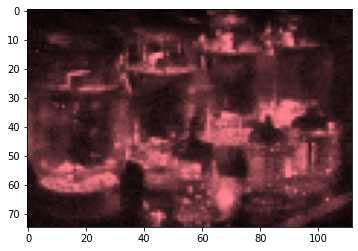

In [50]:
plt.imshow(output.reshape(75,112,3).cpu().detach().numpy())

In [51]:
torch.linalg.norm(output - im_true_flat)

tensor(23.1824, device='cuda:0', grad_fn=<CopyBackwards>)